# Testing Saved Depth CNN Model

This notebook loads the trained depth estimation model from `models/depth_cnn_model.pth` and evaluates it on the test set.

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [2]:
# Define the DepthCNN architecture (must match the saved model)
class DepthCNN(nn.Module):
    """
    CNN for depth estimation (regression task) based on FirstCNN architecture.
    Predicts a single continuous depth value (minmax_depth) instead of classes.
    """
    def __init__(self):
        super(DepthCNN, self).__init__()

        # Conv layers - same as FirstCNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    
        # Other layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4, padding=0)
        self.relu = nn.ReLU()

        # After 4 pooling layers: 256 -p-> 128 -p-> 64 -p-> 32 -p2-> 8

        # Fully connected layers for regression
        self.fc1 = nn.Linear(256 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.5)
        
        # Single output for depth (continuous value between 0 and 1)
        self.depth_output = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool2(self.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        depth = self.depth_output(x)
        return depth

print("✅ DepthCNN architecture defined")

✅ DepthCNN architecture defined


In [4]:
# Load the saved model
model_path = 'models/depth_cnn_model.pth'

# Create model instance
model = DepthCNN()

# Load checkpoint (weights_only=False since we trust our own trained model)
checkpoint = torch.load(model_path, map_location=device, weights_only=False)

# Load model weights
model.load_state_dict(checkpoint['model_state_dict'])

# Move model to device and set to evaluation mode
model = model.to(device)
model.eval()

print(f"✅ Model loaded from: {model_path}")
print(f"\nSaved Model Performance:")
print(f"  - Architecture: {checkpoint['model_architecture']}")
print(f"  - Training Epochs: {checkpoint['epoch']}")
print(f"  - Test Loss (MSE): {checkpoint['test_loss']:.6f}")
print(f"  - Test MAE: {checkpoint['test_mae']:.6f}")
print(f"  - Test RMSE: {checkpoint['test_rmse']:.6f}")
print(f"  - R² Score: {checkpoint['r2_score']:.4f}")

✅ Model loaded from: models/depth_cnn_model.pth

Saved Model Performance:
  - Architecture: DepthCNN
  - Training Epochs: 30
  - Test Loss (MSE): 0.003656
  - Test MAE: 0.047632
  - Test RMSE: 0.060467
  - R² Score: 0.9599


In [9]:
# Define Dataset class for depth estimation
class DepthDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['relative_path']
        image = plt.imread(img_path)
        depth = self.dataframe.iloc[idx]['depth']  # Use minmax_depth

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(depth, dtype=torch.float32)

print("✅ DepthDataset class defined")

✅ DepthDataset class defined


In [10]:
# Load the dataset using the cached CSV (same as main.ipynb)
df = pd.read_csv('labeled_dataset.csv')

# Split data (use same random state as training for consistency)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Dataset sizes:")
print(f"  - Training: {len(train_df)}")
print(f"  - Validation: {len(val_df)}")
print(f"  - Test: {len(test_df)}")

# Create test dataset and dataloader
test_dataset = DepthDataset(test_df, transform=ToTensor())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"\n✅ Test dataset loaded: {len(test_dataset)} images")

Dataset sizes:
  - Training: 1400
  - Validation: 300
  - Test: 300

✅ Test dataset loaded: 300 images


In [11]:
# Evaluate the model on test set
def evaluate_depth_model(model, data_loader, device):
    model.eval()
    criterion = nn.MSELoss()
    
    all_predictions = []
    all_targets = []
    total_loss = 0.0
    
    with torch.no_grad():
        for images, depths in data_loader:
            images = images.to(device)
            depths = depths.to(device).unsqueeze(1)  # Shape: (batch_size, 1)
            
            # Forward pass
            depth_outputs = model(images)
            loss = criterion(depth_outputs, depths)
            
            total_loss += loss.item()
            
            # Store predictions and targets
            all_predictions.extend(depth_outputs.cpu().numpy().flatten())
            all_targets.extend(depths.cpu().numpy().flatten())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    # Calculate metrics
    avg_loss = total_loss / len(data_loader)
    mae = np.mean(np.abs(all_predictions - all_targets))
    rmse = np.sqrt(np.mean((all_predictions - all_targets) ** 2))
    r2 = r2_score(all_targets, all_predictions)
    
    return avg_loss, mae, rmse, r2, all_predictions, all_targets

# Run evaluation
print("Evaluating model on test set...\n")
test_loss, test_mae, test_rmse, test_r2, predictions, targets = evaluate_depth_model(model, test_loader, device)

print("=" * 50)
print("TEST SET RESULTS")
print("=" * 50)
print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"Test MAE:        {test_mae:.6f}")
print(f"Test RMSE:       {test_rmse:.6f}")
print(f"R² Score:        {test_r2:.4f}")
print("=" * 50)

# Compare with saved metrics
print("\nComparison with saved checkpoint:")
print(f"  MSE  - Saved: {checkpoint['test_loss']:.6f}, Current: {test_loss:.6f}")
print(f"  MAE  - Saved: {checkpoint['test_mae']:.6f}, Current: {test_mae:.6f}")
print(f"  RMSE - Saved: {checkpoint['test_rmse']:.6f}, Current: {test_rmse:.6f}")
print(f"  R²   - Saved: {checkpoint['r2_score']:.4f}, Current: {test_r2:.4f}")

Evaluating model on test set...



/opt/anaconda3/envs/DL/lib/python3.13/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


TEST SET RESULTS
Test Loss (MSE): 0.003332
Test MAE:        0.043709
Test RMSE:       0.055976
R² Score:        0.9699

Comparison with saved checkpoint:
  MSE  - Saved: 0.003656, Current: 0.003332
  MAE  - Saved: 0.047632, Current: 0.043709
  RMSE - Saved: 0.060467, Current: 0.055976
  R²   - Saved: 0.9599, Current: 0.9699


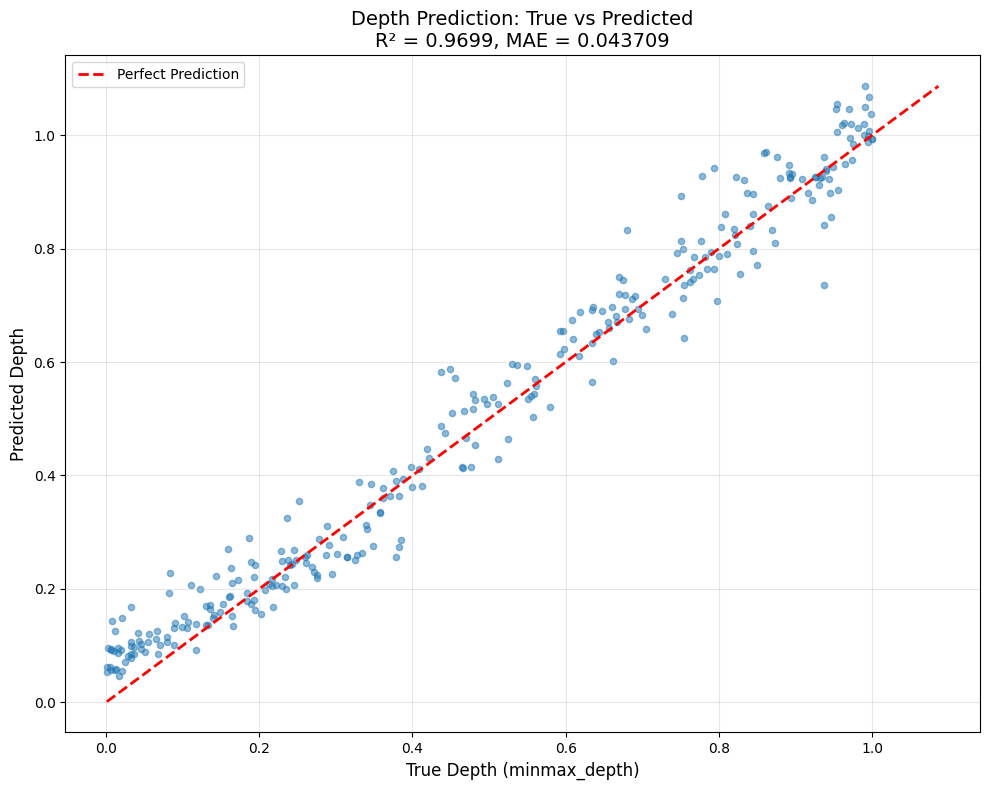

In [12]:
# Visualize predictions vs actual values (scatter plot)
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(targets, predictions, alpha=0.5, s=20)

# Perfect prediction line
min_val = min(targets.min(), predictions.min())
max_val = max(targets.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.xlabel('True Depth (minmax_depth)', fontsize=12)
plt.ylabel('Predicted Depth', fontsize=12)
plt.title(f'Depth Prediction: True vs Predicted\nR² = {test_r2:.4f}, MAE = {test_mae:.6f}', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

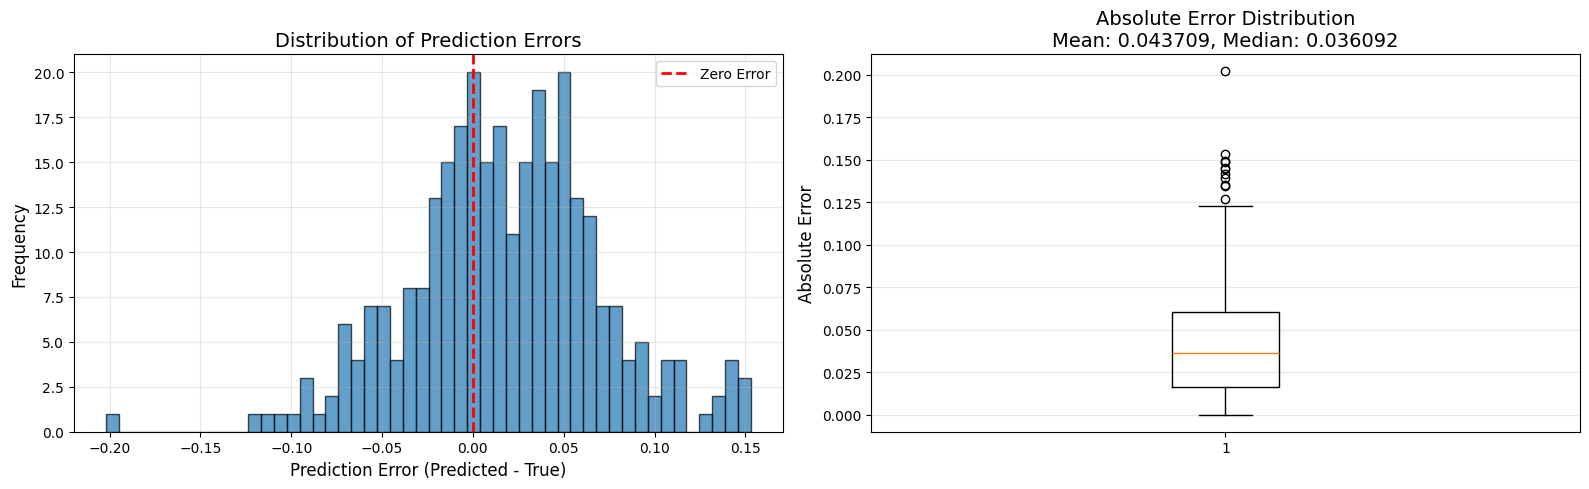

Error Statistics:
  Mean error: 0.018290
  Std error:  0.052904
  Min error:  -0.201858
  Max error:  0.153064


In [13]:
# Visualize error distribution
errors = predictions - targets

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram of errors
axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_xlabel('Prediction Error (Predicted - True)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Prediction Errors', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Box plot of absolute errors
abs_errors = np.abs(errors)
axes[1].boxplot(abs_errors, vert=True)
axes[1].set_ylabel('Absolute Error', fontsize=12)
axes[1].set_title(f'Absolute Error Distribution\nMean: {abs_errors.mean():.6f}, Median: {np.median(abs_errors):.6f}', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Error Statistics:")
print(f"  Mean error: {errors.mean():.6f}")
print(f"  Std error:  {errors.std():.6f}")
print(f"  Min error:  {errors.min():.6f}")
print(f"  Max error:  {errors.max():.6f}")

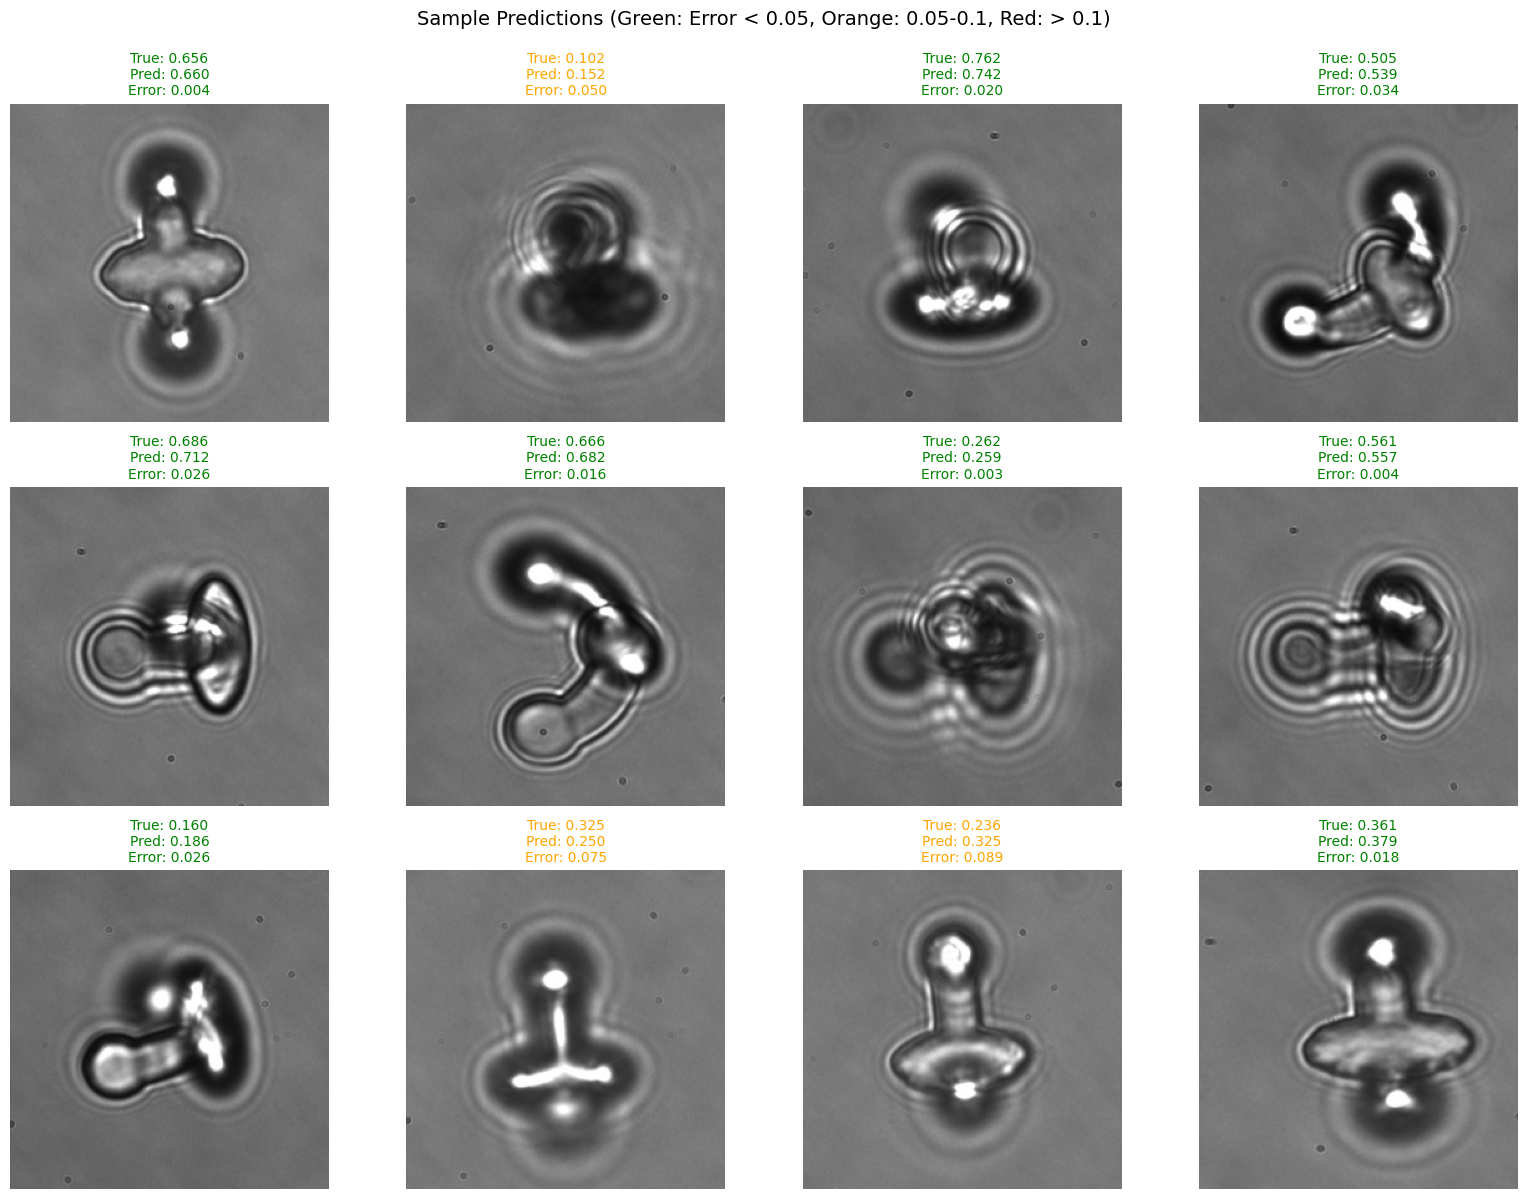

In [14]:
# Visualize sample predictions
def visualize_predictions(model, dataset, device, num_samples=12):
    model.eval()
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_depth = dataset[idx]
            
            # Get prediction
            image_batch = image.unsqueeze(0).to(device)
            pred_depth = model(image_batch).cpu().item()
            
            # Convert image for display
            img_display = image.permute(1, 2, 0).numpy()
            
            # Calculate error
            error = abs(pred_depth - true_depth.item())
            
            # Color code by error magnitude
            if error < 0.05:
                color = 'green'
            elif error < 0.1:
                color = 'orange'
            else:
                color = 'red'
            
            # Display image
            axes[i].imshow(img_display)
            axes[i].axis('off')
            
            # Add title with prediction info
            title = f"True: {true_depth.item():.3f}\nPred: {pred_depth:.3f}\nError: {error:.3f}"
            axes[i].set_title(title, fontsize=10, color=color)
    
    plt.suptitle('Sample Predictions (Green: Error < 0.05, Orange: 0.05-0.1, Red: > 0.1)', 
                 fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, test_dataset, device, num_samples=12)

In [15]:
# Final Summary
print("=" * 60)
print("DEPTH CNN MODEL TEST SUMMARY")
print("=" * 60)
print(f"Model Path: {model_path}")
print(f"Architecture: {checkpoint['model_architecture']}")
print(f"Training Epochs: {checkpoint['epoch']}")
print(f"\nTest Set Size: {len(test_dataset)} images")
print(f"\nPerformance Metrics:")
print(f"  - MSE Loss:  {test_loss:.6f}")
print(f"  - MAE:       {test_mae:.6f}")
print(f"  - RMSE:      {test_rmse:.6f}")
print(f"  - R² Score:  {test_r2:.4f}")
print(f"\nInterpretation:")
print(f"  - On average, predictions are off by {test_mae:.4f} units (MAE)")
print(f"  - The model explains {test_r2*100:.2f}% of the variance in depth (R²)")
print(f"  - {'Excellent' if test_r2 > 0.9 else 'Good' if test_r2 > 0.7 else 'Moderate'} model performance")
print("=" * 60)

DEPTH CNN MODEL TEST SUMMARY
Model Path: models/depth_cnn_model.pth
Architecture: DepthCNN
Training Epochs: 30

Test Set Size: 300 images

Performance Metrics:
  - MSE Loss:  0.003332
  - MAE:       0.043709
  - RMSE:      0.055976
  - R² Score:  0.9699

Interpretation:
  - On average, predictions are off by 0.0437 units (MAE)
  - The model explains 96.99% of the variance in depth (R²)
  - Excellent model performance
